In [1]:
#导入第三方库
import torch #pytorch框架
import pandas as pd #数据集读入库
import matplotlib.pyplot as plt #绘制图表
import torch.nn as nn #模型中的网络层使用
from torch import optim #优化器使用
from torch.utils.data import DataLoader, TensorDataset #数据集处理
from sklearn.model_selection import  train_test_split #数据划分

In [2]:
def round_half_int(x):
    return round(x * 2) / 2

In [3]:
def compute_accuracy(predictions, targets, threshold=0.5):
#param predictions: 预测值
#param targets: 真实值
#param threshold: 判定为正确预测的阈值
    correct = torch.abs(predictions - targets) <= threshold
    return correct.float().mean()
def round_to_nearest_half(tensor):
    return torch.round(tensor * 2) / 2

In [4]:
#读取文件
movies_df = pd.read_csv("./movies.csv")
ratings_df = pd.read_csv("./ratings.csv")
tags_df = pd.read_csv("./tags.csv")

In [5]:
tags_df.drop(columns=['timestamp','userId'],inplace=True)# 删除不需要的行
tags_df = tags_df.drop_duplicates(subset="movieId", keep="first")# 删除重复的标签，只保留一个

In [6]:
tags_df

,movieId,tag
0,60756,funny
3,89774,Boxing story
6,106782,drugs
9,48516,way too long
10,431,Al Pacino
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [7]:
merged_movies_rating_df = pd.merge(ratings_df,movies_df,on="movieId",how="inner") #将打分和电影信息进行整合到一份表中
merged_movies_rating_tags_df = pd.merge(merged_movies_rating_df,tags_df,on=['movieId'],how="outer") #将打分和电影信息和标签整合到一份表中
merged_movies_rating_tags_df=merged_movies_rating_tags_df.dropna(subset=['rating', 'title'])#没有评分或者标题的都滚蛋
merged_movies_rating_tags_df['tag'] = merged_movies_rating_tags_df['tag'].fillna("noTags")#没有标签也是一种标签

In [8]:
merged_movies_rating_tags_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
...,...,...,...,...,...,...,...
100831,610.0,160341,2.5,1.479546e+09,Bloodmoon (1997),Action|Thriller,noTags
100832,610.0,160527,4.5,1.479545e+09,Sympathy for the Underdog (1971),Action|Crime|Drama,noTags
100833,610.0,160836,3.0,1.493845e+09,Hazard (2005),Action|Drama|Thriller,noTags
100834,610.0,163937,3.5,1.493849e+09,Blair Witch (2016),Horror|Thriller,noTags


In [9]:
#merged_movies_rating_tags_df.to_excel('merged_movies_rating_tags_df.xlsx', index=False)

In [10]:
# 将"genres"列分割成多个列
genres_split = merged_movies_rating_tags_df['genres'].str.get_dummies('|')  #使用get_dummies这个方法将genres这一列的数据分割出来形成新的特征列
# 将新生成的列与原始数据合并
df = pd.concat([merged_movies_rating_tags_df, genres_split], axis=1)
#删除generes列
df.drop(columns=["genres"],inplace=True)

In [11]:
df

,userId,movieId,rating,timestamp,title,tag,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),pixar,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),pixar,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),pixar,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),pixar,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),pixar,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610.0,160341,2.5,1.479546e+09,Bloodmoon (1997),noTags,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610.0,160527,4.5,1.479545e+09,Sympathy for the Underdog (1971),noTags,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610.0,160836,3.0,1.493845e+09,Hazard (2005),noTags,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610.0,163937,3.5,1.493849e+09,Blair Witch (2016),noTags,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [12]:
df['title'] = df['title'].astype('category').cat.codes # 为电影标题创建唯一的整数编码
df['tag'] = df['tag'].astype('category').cat.codes# 为电影标签创建唯一的整数编码

In [13]:
df

,userId,movieId,rating,timestamp,title,tag,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,4.0,9.649827e+08,8871,604,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5.0,1,4.0,8.474350e+08,8871,604,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7.0,1,4.5,1.106636e+09,8871,604,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15.0,1,2.5,1.510578e+09,8871,604,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17.0,1,4.5,1.305696e+09,8871,604,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610.0,160341,2.5,1.479546e+09,1193,588,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610.0,160527,4.5,1.479545e+09,8251,588,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610.0,160836,3.0,1.493845e+09,3818,588,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610.0,163937,3.5,1.493849e+09,1150,588,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [14]:
df.info() #检索信息

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userId              100836 non-null  float64
 1   movieId             100836 non-null  int64  
 2   rating              100836 non-null  float64
 3   timestamp           100836 non-null  float64
 4   title               100836 non-null  int16  
 5   tag                 100836 non-null  int16  
 6   (no genres listed)  100836 non-null  int64  
 7   Action              100836 non-null  int64  
 8   Adventure           100836 non-null  int64  
 9   Animation           100836 non-null  int64  
 10  Children            100836 non-null  int64  
 11  Comedy              100836 non-null  int64  
 12  Crime               100836 non-null  int64  
 13  Documentary         100836 non-null  int64  
 14  Drama               100836 non-null  int64  
 15  Fantasy             100836 non-nul

In [15]:
#同一电影的打分取平均值
rating_df = df.groupby(['movieId'])['rating'].mean().apply(round_half_int).reset_index()

In [16]:
rating_df

,movieId,rating
0,1,4.0
1,2,3.5
2,3,3.5
3,4,2.5
4,5,3.0
...,...,...
9719,193581,4.0
9720,193583,3.5
9721,193585,3.5
9722,193587,3.5


In [17]:
df_unique = df.drop_duplicates(subset='movieId', keep='first')# 删除同一movie_id的重复数据，只保留一个
df_unique=df_unique.drop(columns=['rating'])# 删除rating列
df_unique = pd.merge(df_unique, rating_df, on='movieId')# 将处理过的平均分合并到数据集

In [18]:
df_unique

,userId,movieId,timestamp,title,tag,(no genres listed),Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1.0,1,9.649827e+08,8871,604,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,4.0
1,1.0,3,9.649812e+08,3661,570,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3.5
2,1.0,6,9.649822e+08,3845,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,4.0
3,1.0,47,9.649838e+08,7523,584,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.0
4,1.0,50,9.649829e+08,9119,564,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,610.0,160341,1.479546e+09,1193,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,2.5
9720,610.0,160527,1.479545e+09,8251,588,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.5
9721,610.0,160836,1.493845e+09,3818,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,3.0
9722,610.0,163937,1.493849e+09,1150,588,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,3.5


In [19]:
# 合并唯一投票结果到原始数据集
df = df_unique.copy()
df

,userId,movieId,timestamp,title,tag,(no genres listed),Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1.0,1,9.649827e+08,8871,604,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,4.0
1,1.0,3,9.649812e+08,3661,570,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3.5
2,1.0,6,9.649822e+08,3845,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,4.0
3,1.0,47,9.649838e+08,7523,584,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.0
4,1.0,50,9.649829e+08,9119,564,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,610.0,160341,1.479546e+09,1193,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,2.5
9720,610.0,160527,1.479545e+09,8251,588,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.5
9721,610.0,160836,1.493845e+09,3818,588,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,3.0
9722,610.0,163937,1.493849e+09,1150,588,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,3.5


In [20]:
df=df.drop(columns=["userId"])#删除useId
df=df.drop(columns=["timestamp"])#删除时间

In [21]:
df

,movieId,title,tag,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,8871,604,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,4.0
1,3,3661,570,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.5
2,6,3845,588,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4.0
3,47,7523,584,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.0
4,50,9119,564,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,160341,1193,588,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.5
9720,160527,8251,588,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.5
9721,160836,3818,588,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.0
9722,163937,1150,588,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,3.5


In [22]:
df.shape #观察数据量和特征列数量

(9724, 24)

In [23]:
# 数据划分选取特征列和目标列
features = df.iloc[:,df.columns!='rating'].values
target = df.iloc[:,df.columns=='rating'].values

In [24]:
features

array([[     1,   8871,    604, ...,      0,      0,      0],
       [     3,   3661,    570, ...,      0,      0,      0],
       [     6,   3845,    588, ...,      1,      0,      0],
       ...,
       [160836,   3818,    588, ...,      1,      0,      0],
       [163937,   1150,    588, ...,      1,      0,      0],
       [163981,    107,    588, ...,      0,      0,      0]], dtype=int64)

In [25]:
target

array([[4. ],
       [3.5],
       [4. ],
       ...,
       [3. ],
       [3.5],
       [3.5]])

In [26]:
#划分第一个训练集和测试集
X_train,X_test,Y_train,Y_test = train_test_split(features,target,test_size=0.1,random_state=99)

In [27]:
# 划分第二个训练集和测试集
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(features, target, test_size=0.1, random_state=2021)

# 划分第三个训练集和测试集
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(features, target, test_size=0.1, random_state=2000)

In [28]:
#数据转换，转换成为能够使用torch训练类型和验证的类型
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test,dtype=torch.float32)
X_train_2_tensor = torch.tensor(X_train_2, dtype=torch.float32)
Y_train_2_tensor = torch.tensor(Y_train_2,dtype=torch.float32)
X_test_2_tensor = torch.tensor(X_test_2,dtype=torch.float32)
Y_test_2_tensor = torch.tensor(Y_test_2,dtype=torch.float32)
X_train_3_tensor = torch.tensor(X_train_3, dtype=torch.float32)
Y_train_3_tensor = torch.tensor(Y_train_3,dtype=torch.float32)
X_test_3_tensor = torch.tensor(X_test_3,dtype=torch.float32)
Y_test_3_tensor = torch.tensor(Y_test_3,dtype=torch.float32)

In [29]:
Y_train_tensor

tensor([[3.0000],
        [3.0000],
        [3.0000],
        ...,
        [3.0000],
        [3.5000],
        [4.5000]])

In [30]:
X_train_tensor

tensor([[7.9242e+04, 4.7320e+03, 5.8800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.9306e+04, 8.2820e+03, 5.8800e+02,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4170e+03, 2.0400e+03, 5.8800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0100e+03, 5.2460e+03, 9.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2310e+03, 7.8310e+03, 5.8800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.1435e+04, 7.2550e+03, 5.8800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [31]:
#数据转换为批次进行训练
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
train_data_2 = TensorDataset(X_train_2_tensor, Y_train_2_tensor)
train_loader_2 = DataLoader(train_data_2, batch_size=128, shuffle=True)
train_data_3 = TensorDataset(X_train_3_tensor, Y_train_3_tensor)
train_loader_3 = DataLoader(train_data_3, batch_size=128, shuffle=True)

In [31]:
#多层感知机模型参数
#创建多层感知机模型，神经网络
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * ((input_size - 2) // 2), 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32,16)
        self.fc6 = nn.Linear(16,1)


    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = nn.functional.relu(x)
        x = self.fc5(x)
        x = nn.functional.relu(x)
        x = self.fc6(x)
        return x

In [35]:
class EnhancedSimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(EnhancedSimpleMLP, self).__init__()
        # 简化的全连接网络结构
        self.fc1 = nn.Linear(input_size, 128)  # 第一个全连接层
        self.fc2 = nn.Linear(128, 64)      # 第二个全连接层
        self.fc3 = nn.Linear(64, 32)       # 第三个全连接层
        self.fc4 = nn.Linear(32, 16)       # 新增的全连接层
        self.fc5 = nn.Linear(16, 1)      # 输出层，输出一个值表示评分

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # 使用ReLU激活函数
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))  # 新增层也使用ReLU激活函数
        x = self.fc5(x)        # 输出层不使用激活函数
        return x


In [39]:
epochs = 300
num_lr_1=0.001
num_lr_2=0.003
num_lr_3=0.003

In [40]:
model = SimpleMLP(X_train.shape[1]) # 输入量为特征列的数量

# 使用均方误差损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), num_lr_1)

model_acc = 0.0
train_loss_data_1 = []
test_loss_data_1 = []

for epoch in range(epochs):
    model.train()
    total_loss = 0  # 初始化累积损失值
    total_batches = 0  # 初始化批次计数
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y) 
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_batches+=1
    average_loss = total_loss / total_batches
    train_loss_data_1.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss}")

# 模型评估
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        rounded_outputs = torch.tensor([round_to_nearest_half(x) for x in test_outputs])
        test_loss = criterion(test_outputs, Y_test_tensor)  # 计算测试损失
        test_loss_data_1.append(test_loss.item())
        test_accuracy = compute_accuracy(rounded_outputs, Y_test_tensor)
        print(f'Test Loss: {test_loss.item()}')

# 打印准确率
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')
    if model_acc < test_accuracy*100:
        model_acc = test_accuracy*100
print(f'Test Accuracy max: {model_acc:.2f}%')

Epoch 1/300, Average Loss: 4275.880200372226
Test Loss: 11.162002563476562
Test Accuracy: 14.49%
Epoch 2/300, Average Loss: 8.667157504869545
Test Loss: 5.6999030113220215
Test Accuracy: 26.00%
Epoch 3/300, Average Loss: 2.6321073062178018
Test Loss: 1.8406301736831665
Test Accuracy: 45.85%
Epoch 4/300, Average Loss: 3.8414135618486265
Test Loss: 4.9933552742004395
Test Accuracy: 33.44%
Epoch 5/300, Average Loss: 1.713995451512544
Test Loss: 1.2188149690628052
Test Accuracy: 54.20%
Epoch 6/300, Average Loss: 1.383601843446925
Test Loss: 1.1739939451217651
Test Accuracy: 56.08%
Epoch 7/300, Average Loss: 1.6805477556974993
Test Loss: 1.2020463943481445
Test Accuracy: 55.93%
Epoch 8/300, Average Loss: 1.5184804382531538
Test Loss: 1.4847456216812134
Test Accuracy: 49.92%
Epoch 9/300, Average Loss: 2.273307790790779
Test Loss: 1.0966429710388184
Test Accuracy: 54.34%
Epoch 10/300, Average Loss: 2.7424597152765244
Test Loss: 5.210600852966309
Test Accuracy: 31.26%
Epoch 11/300, Average Los

Test Loss: 1.0583289861679077
Test Accuracy: 55.56%
Epoch 86/300, Average Loss: 1.2606722228768943
Test Loss: 1.3129830360412598
Test Accuracy: 50.59%
Epoch 87/300, Average Loss: 2.009367282839789
Test Loss: 0.950281023979187
Test Accuracy: 56.85%
Epoch 88/300, Average Loss: 1.1399665803149126
Test Loss: 0.9507584571838379
Test Accuracy: 58.30%
Epoch 89/300, Average Loss: 1.5066641577775928
Test Loss: 1.132059097290039
Test Accuracy: 58.11%
Epoch 90/300, Average Loss: 1.3134514266166135
Test Loss: 1.364668846130371
Test Accuracy: 52.42%
Epoch 91/300, Average Loss: 1.5129448702369912
Test Loss: 1.1165316104888916
Test Accuracy: 54.22%
Epoch 92/300, Average Loss: 1.3827284151229307
Test Loss: 0.9874305129051208
Test Accuracy: 54.93%
Epoch 93/300, Average Loss: 5.187147549960924
Test Loss: 1.2062232494354248
Test Accuracy: 49.67%
Epoch 94/300, Average Loss: 1.3240612779838452
Test Loss: 1.3835970163345337
Test Accuracy: 46.69%
Epoch 95/300, Average Loss: 1.3036473255226577
Test Loss: 3.74

Epoch 169/300, Average Loss: 1.9862018184385437
Test Loss: 1.2279748916625977
Test Accuracy: 53.26%
Epoch 170/300, Average Loss: 1.5357486087342966
Test Loss: 1.1300265789031982
Test Accuracy: 53.02%
Epoch 171/300, Average Loss: 1.1419348345286604
Test Loss: 1.1465777158737183
Test Accuracy: 53.34%
Epoch 172/300, Average Loss: 1.0769475905791572
Test Loss: 1.0810402631759644
Test Accuracy: 53.05%
Epoch 173/300, Average Loss: 1.1087609754092451
Test Loss: 1.0420565605163574
Test Accuracy: 54.99%
Epoch 174/300, Average Loss: 1.0354056427444236
Test Loss: 0.9547483325004578
Test Accuracy: 57.05%
Epoch 175/300, Average Loss: 1.0094271906908008
Test Loss: 0.9997645020484924
Test Accuracy: 52.35%
Epoch 176/300, Average Loss: 1.02005607408026
Test Loss: 1.0175474882125854
Test Accuracy: 55.46%
Epoch 177/300, Average Loss: 0.9967392691667529
Test Loss: 0.9653164148330688
Test Accuracy: 57.85%
Epoch 178/300, Average Loss: 0.9659988197727479
Test Loss: 0.9464293718338013
Test Accuracy: 55.94%
Ep

Test Loss: 0.7579260468482971
Test Accuracy: 58.31%
Epoch 252/300, Average Loss: 0.8260542577591495
Test Loss: 0.8901054859161377
Test Accuracy: 57.25%
Epoch 253/300, Average Loss: 0.8429711037787838
Test Loss: 0.7589946985244751
Test Accuracy: 58.53%
Epoch 254/300, Average Loss: 0.8195942070173181
Test Loss: 0.7523190379142761
Test Accuracy: 60.07%
Epoch 255/300, Average Loss: 0.821005636367245
Test Loss: 0.7771410942077637
Test Accuracy: 57.67%
Epoch 256/300, Average Loss: 0.7921866118044093
Test Loss: 0.8868233561515808
Test Accuracy: 63.19%
Epoch 257/300, Average Loss: 0.8175367954848469
Test Loss: 0.8987655639648438
Test Accuracy: 53.95%
Epoch 258/300, Average Loss: 0.8196056113726851
Test Loss: 0.7885684370994568
Test Accuracy: 61.92%
Epoch 259/300, Average Loss: 0.8118114004964414
Test Loss: 0.8884469866752625
Test Accuracy: 59.81%
Epoch 260/300, Average Loss: 0.7869813856871232
Test Loss: 0.7635195255279541
Test Accuracy: 56.70%
Epoch 261/300, Average Loss: 0.7985899310181106
T

In [46]:
model2 = MLP(X_train_2.shape[1]) # 输入量为特征列的数量

# 使用均方误差损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), num_lr_2)

model2_acc = 0.0 #用于保存第二次模型最好的准确率
train_loss_data_2 = [] #记录第二次训练的损失
test_loss_data_2 = [] #记录第二次的测试的损失

for epoch in range(epochs):
    total_loss = 0  # 初始化累积损失值
    total_batches = 0  # 初始化批次计数
    for batch_X, batch_y in train_loader_2:
        optimizer.zero_grad()
        outputs = model2(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y) 
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_batches+=1
    average_loss = total_loss / total_batches
    train_loss_data_2.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss}")

# 模型评估
    model2.eval()
    with torch.no_grad():
        test_outputs = model2(X_test_2_tensor.unsqueeze(1))
        rounded_outputs = torch.tensor([round_to_nearest_half(x) for x in test_outputs])
        test_loss = criterion(test_outputs, Y_test_tensor)  # 计算测试损失
        test_loss_data_2.append(test_loss.item())
        test_accuracy = compute_accuracy(rounded_outputs, Y_test_2_tensor)
        print(f'Test Loss: {test_loss.item()}')

# 打印准确率
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')
    if model2_acc < test_accuracy*100:
        model2_acc = test_accuracy*100
print(f'Test Accuracy max: {model2_acc:.2f}%')

Epoch 1/50, Average Loss: 431.2904259502024
Test Loss: 3.427905797958374
Test Accuracy: 33.29%
Epoch 2/50, Average Loss: 2.525301848632702
Test Loss: 1.3270280361175537
Test Accuracy: 46.67%
Epoch 3/50, Average Loss: 1.6387392723042031
Test Loss: 1.695830225944519
Test Accuracy: 47.38%
Epoch 4/50, Average Loss: 1.7966878353685574
Test Loss: 1.221426248550415
Test Accuracy: 45.99%
Epoch 5/50, Average Loss: 5.124948997428452
Test Loss: 1.4433519840240479
Test Accuracy: 43.11%
Epoch 6/50, Average Loss: 1.3679564638414246
Test Loss: 1.1465811729431152
Test Accuracy: 50.57%
Epoch 7/50, Average Loss: 1.2055548429489136
Test Loss: 1.1172794103622437
Test Accuracy: 48.46%
Epoch 8/50, Average Loss: 1.220152605270994
Test Loss: 1.0309908390045166
Test Accuracy: 53.58%
Epoch 9/50, Average Loss: 1.2805861891179844
Test Loss: 1.1142020225524902
Test Accuracy: 56.05%
Epoch 10/50, Average Loss: 1.1704317910083826
Test Loss: 2.5413625240325928
Test Accuracy: 45.45%
Epoch 11/50, Average Loss: 1.3337914

In [47]:
model3 = MLP(X_train_3.shape[1]) # 输入量为特征列的数量

# 使用均方误差损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), num_lr_3)

model3_acc = 0.0 #用于保存第二次模型最好的准确率
train_loss_data_3 = [] #记录第二次训练的损失
test_loss_data_3 = [] #记录第二次的测试的损失

for epoch in range(epochs):
    total_loss = 0  # 初始化累积损失值
    total_batches = 0  # 初始化批次计数
    for batch_X, batch_y in train_loader_3:
        optimizer.zero_grad()
        outputs = model3(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y) 
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_batches+=1
    average_loss = total_loss / total_batches
    train_loss_data_3.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss}")

# 模型评估
    model3.eval()
    with torch.no_grad():
        test_outputs = model3(X_test_3_tensor.unsqueeze(1))
        rounded_outputs = torch.tensor([round_to_nearest_half(x) for x in test_outputs])
        test_loss = criterion(test_outputs, Y_test_tensor)  # 计算测试损失
        test_loss_data_3.append(test_loss.item())
        test_accuracy = compute_accuracy(rounded_outputs, Y_test_3_tensor)
        print(f'Test Loss: {test_loss.item()}')

# 打印准确率
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')
    if model3_acc < test_accuracy*100:
        model3_acc = test_accuracy*100
print(f'Test Accuracy max: {model3_acc:.2f}%')

Epoch 1/50, Average Loss: 761.7463966798091
Test Loss: 3.8131895065307617
Test Accuracy: 28.16%
Epoch 2/50, Average Loss: 2.202542866485706
Test Loss: 2.0793943405151367
Test Accuracy: 41.33%
Epoch 3/50, Average Loss: 1.4238063088361768
Test Loss: 1.5197511911392212
Test Accuracy: 41.91%
Epoch 4/50, Average Loss: 1.3403382992398911
Test Loss: 1.4297000169754028
Test Accuracy: 44.68%
Epoch 5/50, Average Loss: 1.2260293347248132
Test Loss: 1.3526452779769897
Test Accuracy: 53.81%
Epoch 6/50, Average Loss: 1.1724973269130872
Test Loss: 1.026128888130188
Test Accuracy: 57.52%
Epoch 7/50, Average Loss: 1.2612892389297485
Test Loss: 1.048207402229309
Test Accuracy: 52.76%
Epoch 8/50, Average Loss: 1.1493161692135576
Test Loss: 0.9851870536804199
Test Accuracy: 56.14%
Epoch 9/50, Average Loss: 1.2136723209118498
Test Loss: 1.1927247047424316
Test Accuracy: 50.94%
Epoch 10/50, Average Loss: 1.2617114609566287
Test Loss: 1.206262469291687
Test Accuracy: 47.61%
Epoch 11/50, Average Loss: 1.17099

In [48]:
avg_acc = (model_acc+model2_acc+model3_acc)/3
print(f"平均准确率:{avg_acc:.2f}%")

平均准确率:63.66%


In [49]:
Y_test.shape

(973, 1)

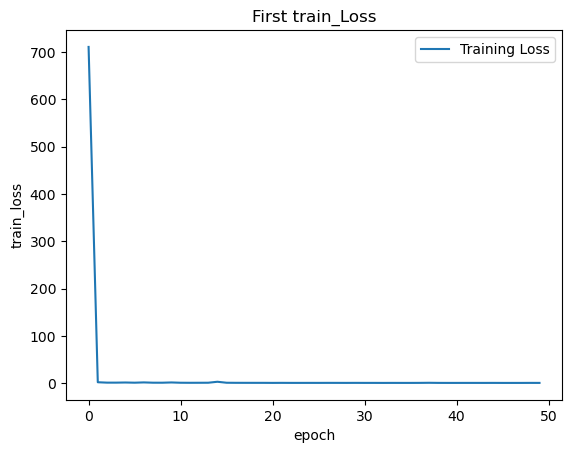

In [50]:
# 将 PyTorch 张量转为 NumPy 数组并去除维度为 1 的维度
# 绘制图表
plt.plot(range(epochs), train_loss_data_1, label='Training Loss')  # 添加 label 参数
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title("First train_Loss")
plt.legend()  # 现在这里将显示"Training Loss"
plt.show()


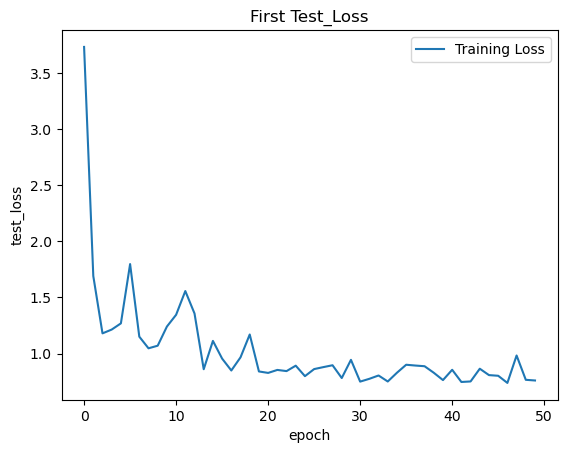

In [51]:
# 绘制图表
plt.plot(range(epochs),test_loss_data_1, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.title("First Test_Loss")
plt.legend()
plt.show()

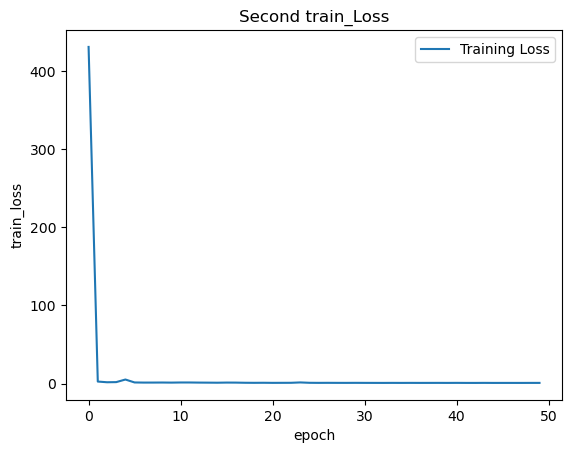

In [52]:
# 绘制图表
plt.plot(range(epochs),train_loss_data_2, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title("Second train_Loss")
plt.legend()
plt.show()


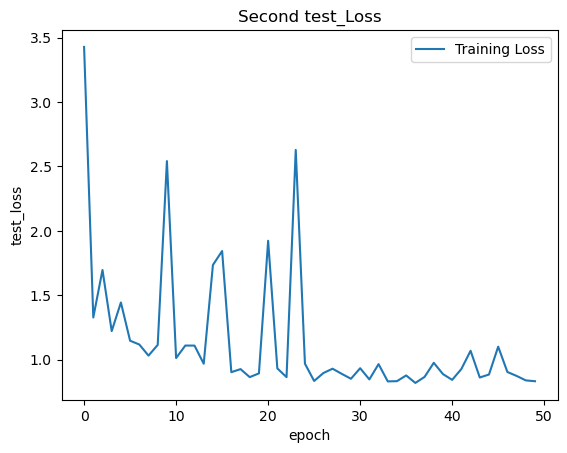

In [53]:
# 绘制图表
plt.plot(range(epochs),test_loss_data_2, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.title("Second test_Loss")
plt.legend()
plt.show()

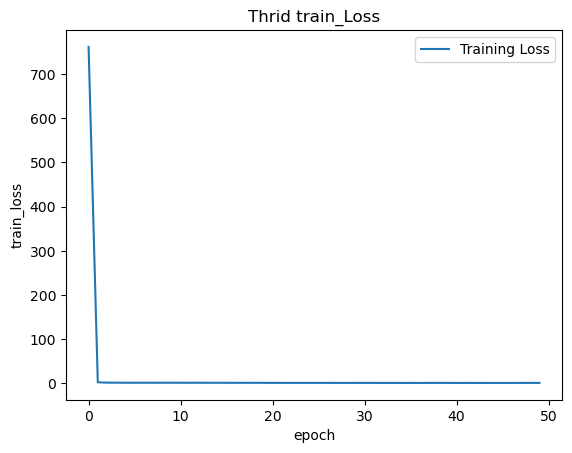

In [54]:
# 绘制图表
plt.plot(range(epochs),train_loss_data_3, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title("Thrid train_Loss")
plt.legend()
plt.show()


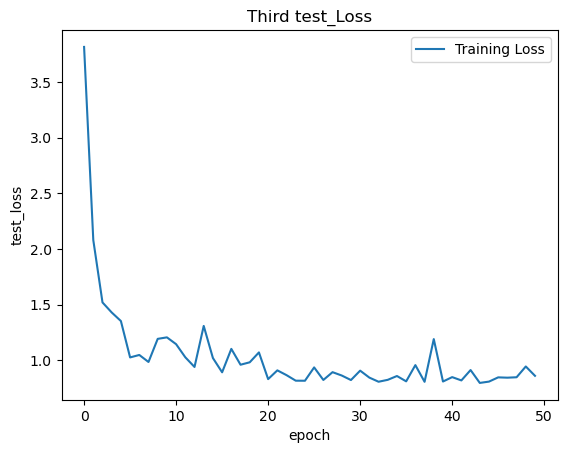

In [55]:
# 绘制图表
plt.plot(range(epochs),test_loss_data_3, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.title("Third test_Loss")
plt.legend()
plt.show()
